# ArXiv Pipeline - MongoDB Analysis

This notebook explores and visualizes the paper metadata stored in MongoDB.

Key analyses include:
- Paper publication trends over time
- Author analytics and rankings
- Category distribution analysis 
- Citation metrics
- Text analysis of titles/abstracts

In [ ]:
# Import required libraries
import os
import re
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from collections import Counter
from dotenv import load_dotenv
from wordcloud import WordCloud
import matplotlib.ticker as ticker

# Load environment variables from .env file (if present)
load_dotenv()

# Set Matplotlib config
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# MongoDB Configuration
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
MONGO_DB = os.getenv("MONGO_DB", "arxiv_papers")

print(f"MongoDB URI: {MONGO_URI}")
print(f"MongoDB Database: {MONGO_DB}")

# Connect to MongoDB
try:
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DB]
    # Test connection
    server_info = client.server_info()
    print(f"✅ Connected to MongoDB (version: {server_info.get('version')})")
    
    # Get collection stats
    print("\nCollection statistics:")
    collections = db.list_collection_names()
    for collection in collections:
        count = db[collection].count_documents({})
        print(f"- {collection}: {count:,} documents")
except Exception as e:
    print(f"❌ Failed to connect to MongoDB: {e}")
    raise

MongoDB URI: mongodb://localhost:27017/
MongoDB Database: arxiv_papers
✅ Connected to MongoDB (version: 8.0.8)

Collection statistics:
- ingestion_stats: 2,551 documents
- papers: 26,141 documents
- processed_pdfs: 17 documents


## 1. Paper Publication Trends Over Time

Let's analyze how the publication volume has changed over time.

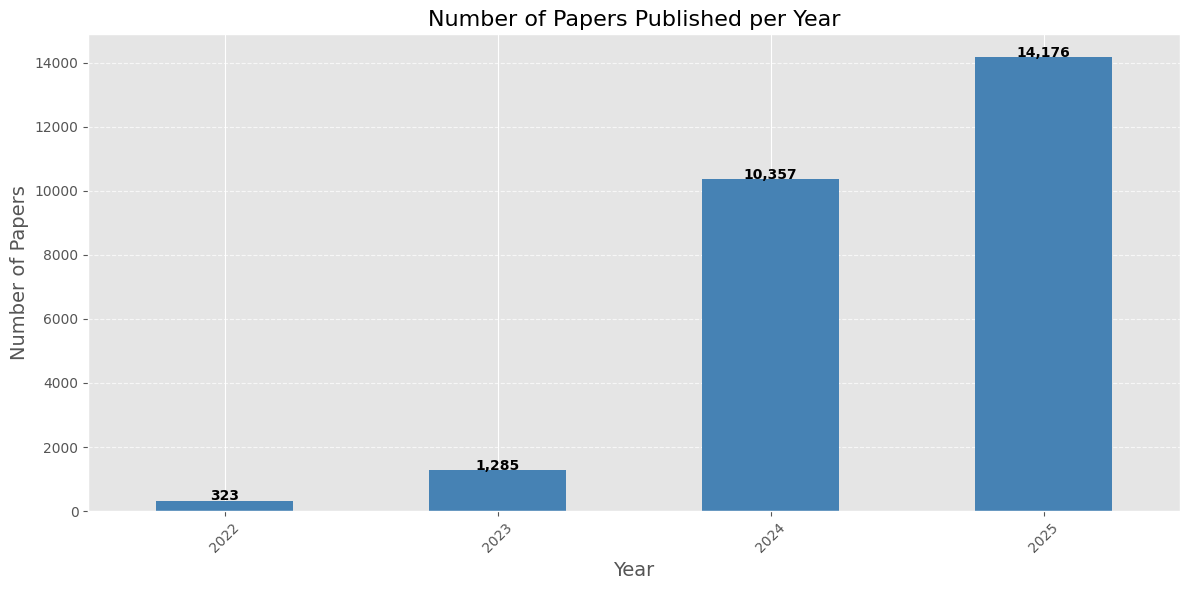

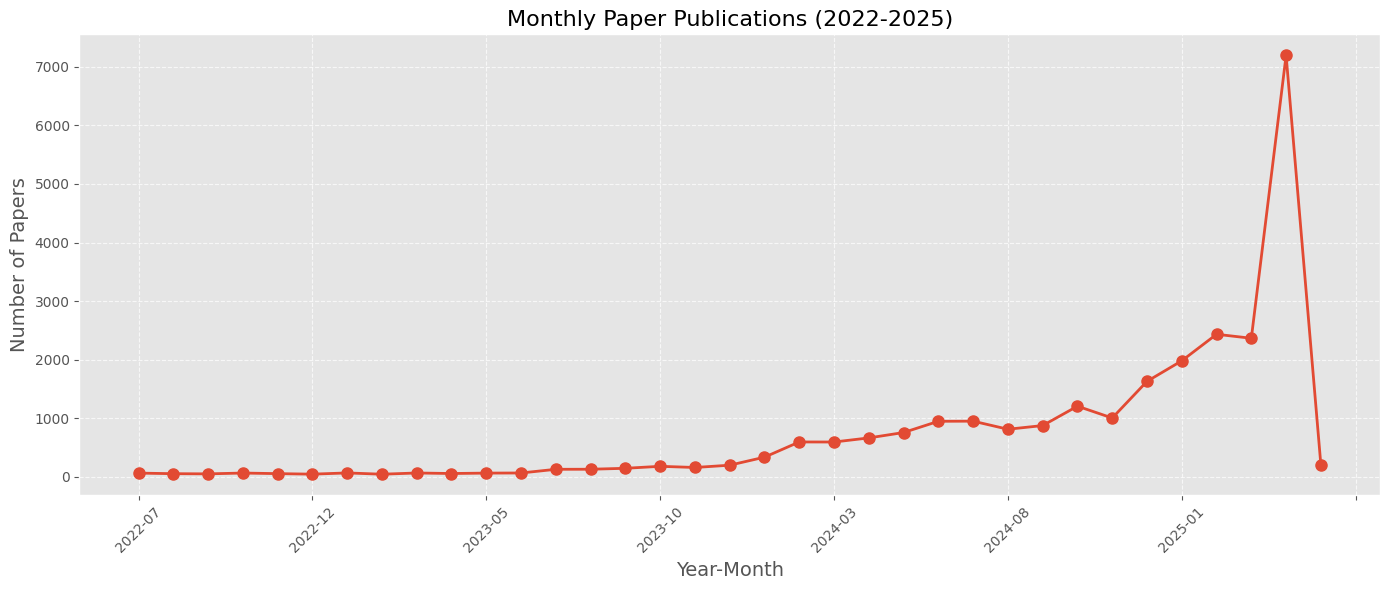

In [ ]:
# Convert to DataFrame for time series analysis
papers_df = pd.DataFrame(list(db.papers.find({}, {'_id': 1, 'id': 1, 'title': 1, 'authors': 1, 'categories': 1, 'update_date': 1, 'published': 1})))

# Convert date strings to datetime objects
papers_df['published_date'] = pd.to_datetime(papers_df['published'], errors='coerce')
papers_df['year'] = papers_df['published_date'].dt.year
papers_df['month'] = papers_df['published_date'].dt.month
papers_df['year_month'] = papers_df['published_date'].dt.strftime('%Y-%m')

# Get papers per year
papers_per_year = papers_df['year'].value_counts().sort_index()

# Plot papers per year
plt.figure(figsize=(12, 6))
ax = papers_per_year.plot(kind='bar', color='steelblue')
plt.title('Number of Papers Published per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of each bar
for i, v in enumerate(papers_per_year):
    ax.text(i, v + 10, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Monthly trend for the last 3 years (if data spans that far)
current_year = datetime.now().year
three_years_ago = current_year - 3

recent_monthly = papers_df[papers_df['year'] >= three_years_ago]
monthly_counts = recent_monthly['year_month'].value_counts().sort_index()

if not monthly_counts.empty:
    plt.figure(figsize=(14, 6))
    monthly_counts.plot(kind='line', marker='o', linewidth=2, markersize=8)
    plt.title(f'Monthly Paper Publications ({three_years_ago}-{current_year})', fontsize=16)
    plt.xlabel('Year-Month', fontsize=14)
    plt.ylabel('Number of Papers', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the last three years.")

## 2. Author Analytics

Let's analyze the most prolific authors and co-authorship patterns.

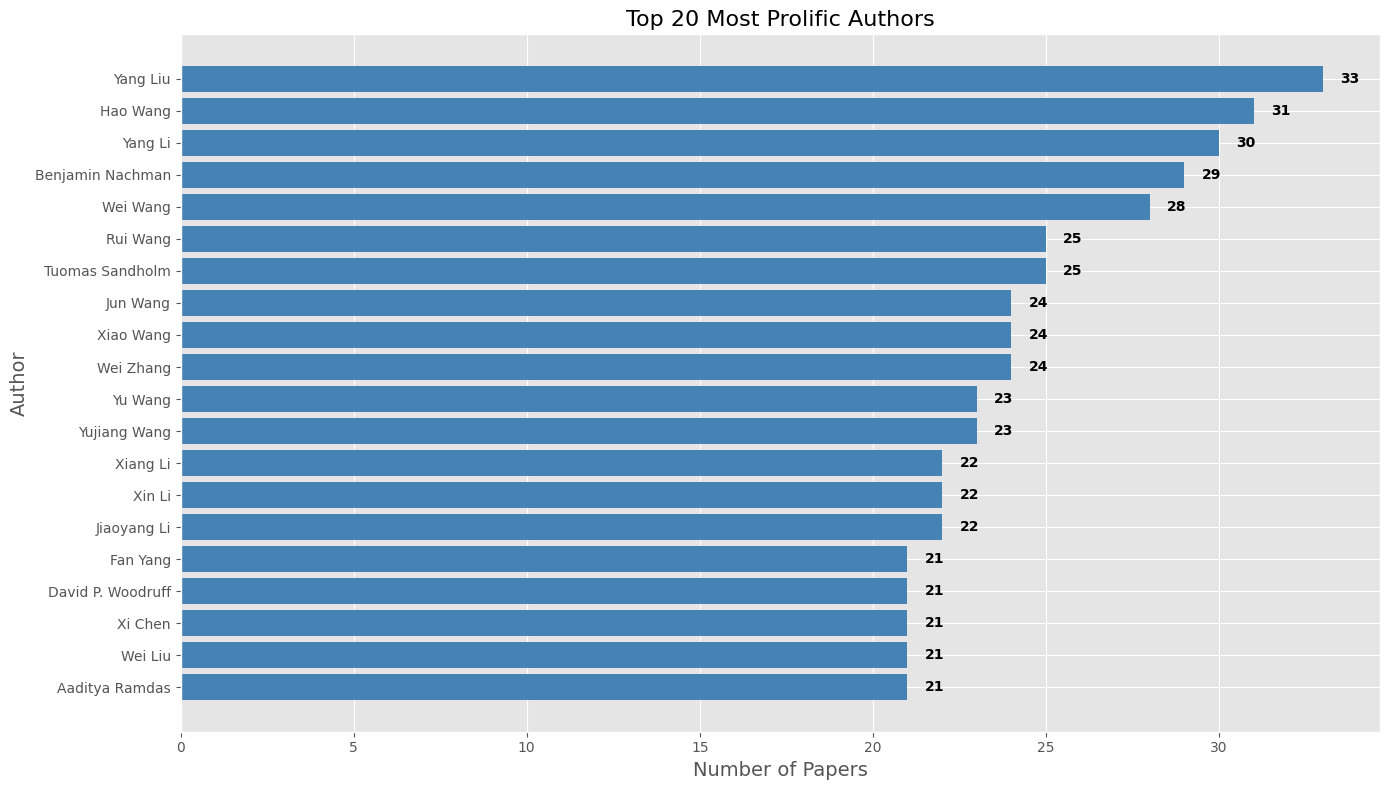

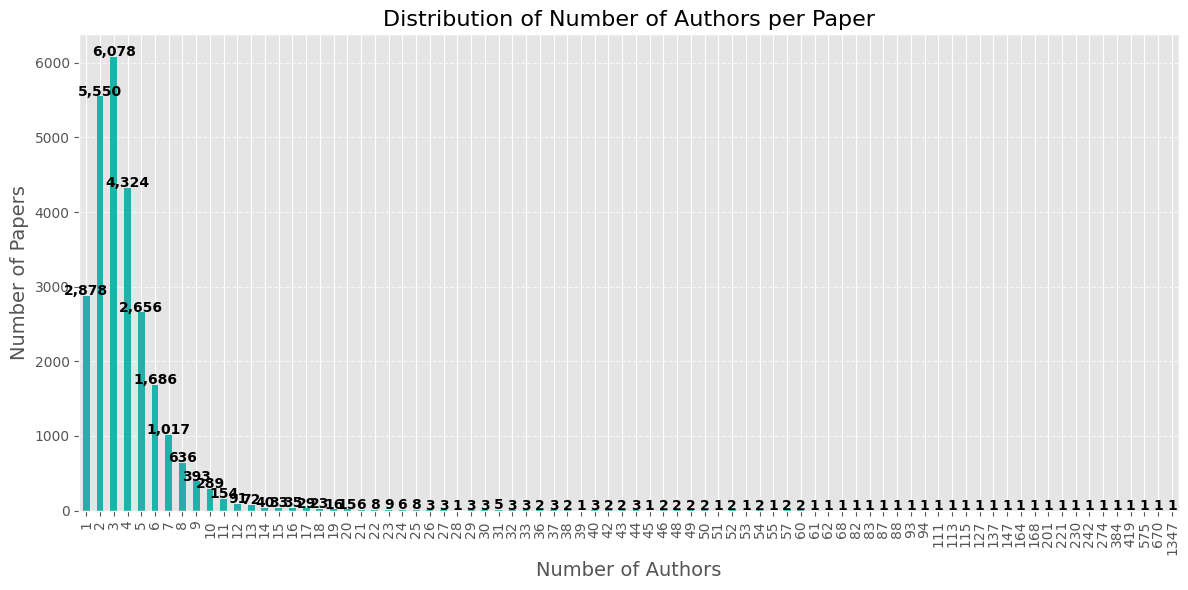

Average number of authors per paper: 4.13


In [ ]:
# Function to extract all authors from papers
def extract_authors(papers_df):
    all_authors = []
    author_paper_count = Counter()
    
    for _, paper in papers_df.iterrows():
        if 'authors' in paper and paper['authors']:
            paper_authors = paper['authors']
            # Add to all authors list
            all_authors.extend(paper_authors)
            # Count papers per author
            for author in paper_authors:
                author_paper_count[author] += 1
    
    return all_authors, author_paper_count

# Get author data
all_authors, author_paper_count = extract_authors(papers_df)

# Most prolific authors (top 20)
top_authors = pd.DataFrame(author_paper_count.most_common(20), 
                           columns=['Author', 'Paper Count'])

# Plot top authors
plt.figure(figsize=(14, 8))
bars = plt.barh(top_authors['Author'], top_authors['Paper Count'], color='steelblue')
plt.title('Top 20 Most Prolific Authors', fontsize=16)
plt.xlabel('Number of Papers', fontsize=14)
plt.ylabel('Author', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top

# Add count labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f"{width:,}", ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Co-authorship analysis: distribution of authors per paper
papers_df['author_count'] = papers_df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)
author_count_dist = papers_df['author_count'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax = author_count_dist.plot(kind='bar', color='lightseagreen')
plt.title('Distribution of Number of Authors per Paper', fontsize=16)
plt.xlabel('Number of Authors', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for i, v in enumerate(author_count_dist):
    ax.text(i, v + 10, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate and display average authors per paper
avg_authors = papers_df['author_count'].mean()
print(f"Average number of authors per paper: {avg_authors:.2f}")

## 3. Category Distribution Analysis

Let's analyze the distribution of categories across papers.

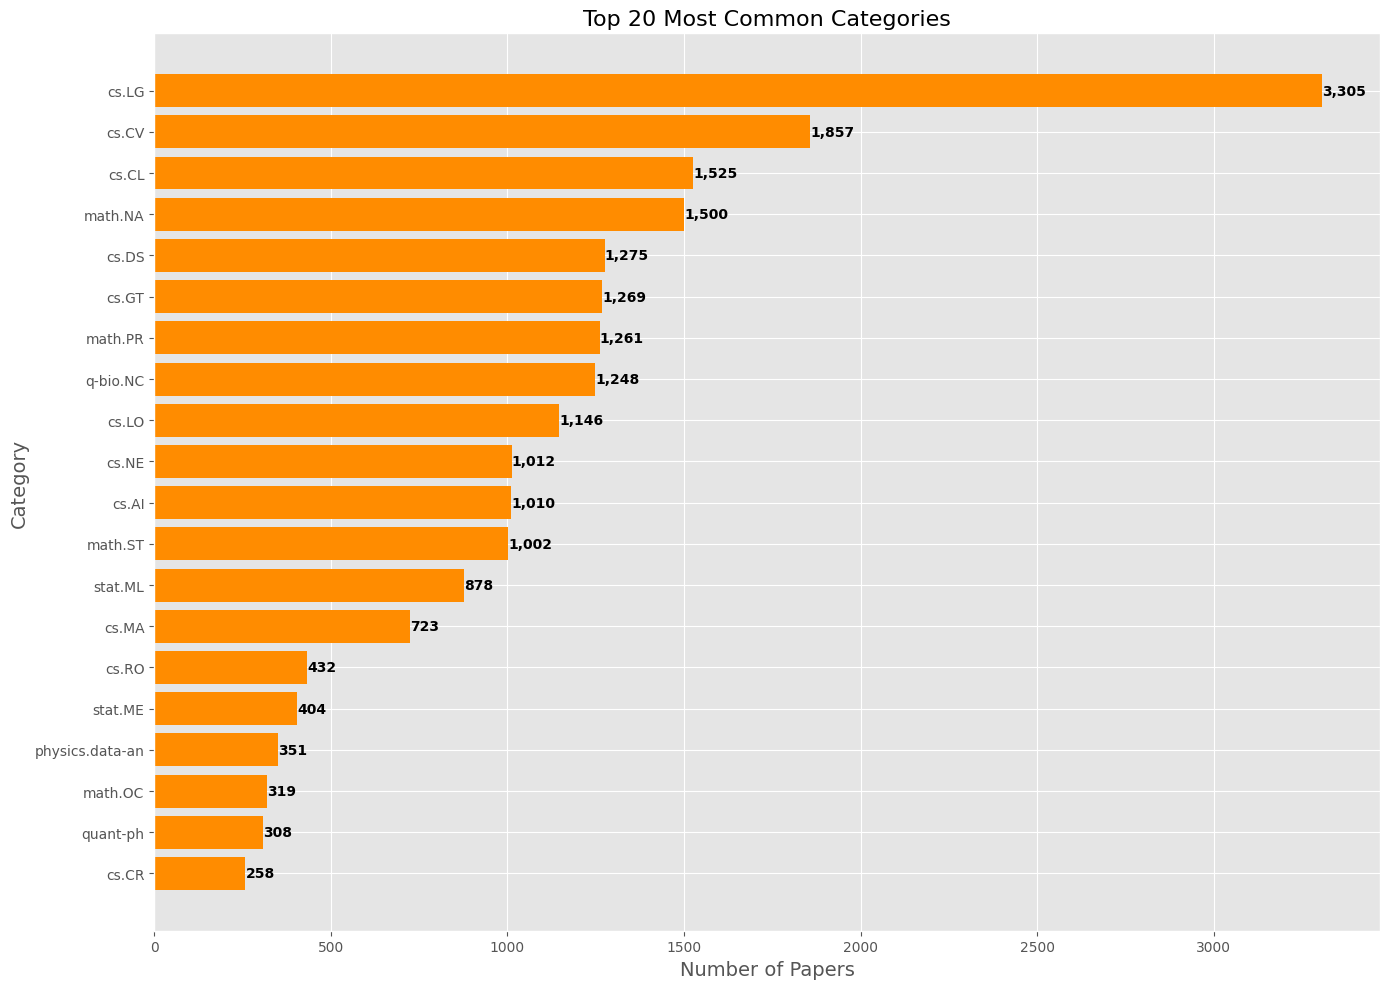

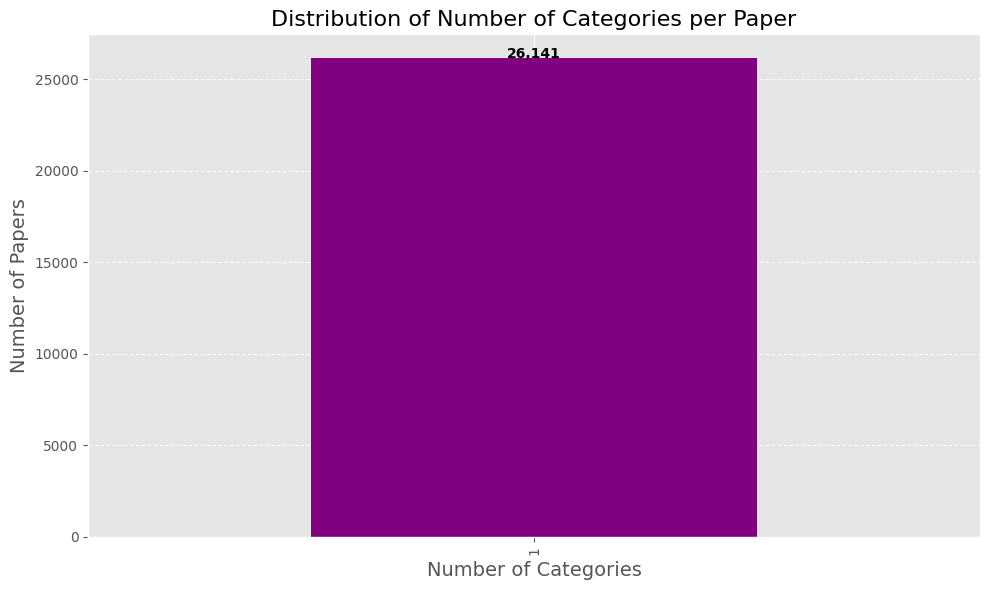

Average number of categories per paper: 1.00


In [ ]:
# Function to extract all categories from papers
def extract_categories(papers_df):
    all_categories = []
    category_paper_count = Counter()
    
    for _, paper in papers_df.iterrows():
        if 'categories' in paper and paper['categories']:
            paper_cats = paper['categories']
            # Add to all categories list
            all_categories.extend(paper_cats)
            # Count papers per category
            for cat in paper_cats:
                category_paper_count[cat] += 1
    
    return all_categories, category_paper_count

# Get category data
all_categories, category_paper_count = extract_categories(papers_df)

# Top categories (top 20)
top_categories = pd.DataFrame(category_paper_count.most_common(20), 
                             columns=['Category', 'Paper Count'])

# Plot top categories
plt.figure(figsize=(14, 10))
bars = plt.barh(top_categories['Category'], top_categories['Paper Count'], color='darkorange')
plt.title('Top 20 Most Common Categories', fontsize=16)
plt.xlabel('Number of Papers', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top

# Add count labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f"{width:,}", ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Distribution of categories per paper
papers_df['category_count'] = papers_df['categories'].apply(lambda x: len(x) if isinstance(x, list) else 0)
category_count_dist = papers_df['category_count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = category_count_dist.plot(kind='bar', color='purple')
plt.title('Distribution of Number of Categories per Paper', fontsize=16)
plt.xlabel('Number of Categories', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for i, v in enumerate(category_count_dist):
    ax.text(i, v + 10, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate and display average categories per paper
avg_categories = papers_df['category_count'].mean()
print(f"Average number of categories per paper: {avg_categories:.2f}")

## 4. Text Analysis of Titles and Abstracts

Let's analyze the content of paper titles and abstracts to identify common terms and research trends.

In [ ]:
# Get sample of papers with abstracts for text analysis
papers_with_abstract = list(db.papers.find({'abstract': {'$exists': True, '$ne': ""}}, 
                                          {'_id': 0, 'title': 1, 'abstract': 1, 'published': 1}))
abstract_df = pd.DataFrame(papers_with_abstract)

print(f"Number of papers with abstracts: {len(abstract_df):,}")

# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove special chars and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

# Process titles
abstract_df['clean_title'] = abstract_df['title'].apply(clean_text)
all_titles = ' '.join(abstract_df['clean_title'].tolist())

# Generate and display word cloud for titles
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white', 
                     collocations=False,
                     max_words=100,
                     contour_width=3).generate(all_titles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Paper Titles", fontsize=16)
plt.tight_layout()
plt.show()

# Process abstracts if available
if 'abstract' in abstract_df.columns and not abstract_df['abstract'].empty:
    abstract_df['clean_abstract'] = abstract_df['abstract'].apply(clean_text)
    all_abstracts = ' '.join(abstract_df['clean_abstract'].tolist())
    
    # Generate and display word cloud for abstracts
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white', 
                         collocations=False,
                         max_words=100,
                         contour_width=3).generate(all_abstracts)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Paper Abstracts", fontsize=16)
    plt.tight_layout()
    plt.show()

Number of papers with abstracts: 0


KeyError: 'title'

## 5. MongoDB Collection Analysis

Let's explore the structure and content of the ingestion_stats and processed_pdfs collections.

In [ ]:
# Analyze ingestion_stats collection
try:
    # Get ingestion stats
    ingestion_stats = list(db.ingestion_stats.find())
    ingestion_df = pd.DataFrame(ingestion_stats)
    
    if not ingestion_df.empty:
        print(f"Ingestion stats collection contains {len(ingestion_df):,} records")
        
        # Convert timestamp to datetime
        if 'timestamp' in ingestion_df.columns:
            ingestion_df['datetime'] = pd.to_datetime(ingestion_df['timestamp'], unit='s')
            
            # Plot ingestion over time
            plt.figure(figsize=(14, 6))
            ingestion_df.sort_values('datetime', inplace=True)
            
            # If we have papers_processed column
            if 'papers_processed' in ingestion_df.columns:
                plt.plot(ingestion_df['datetime'], ingestion_df['papers_processed'], 
                        marker='o', linestyle='-', linewidth=2, markersize=6)
                plt.title('Papers Processed in Each Ingestion Run', fontsize=16)
                plt.xlabel('Ingestion Date', fontsize=14)
                plt.ylabel('Number of Papers Processed', fontsize=14)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            
            # Show statistics
            print("\nIngestion Statistics Summary:")
            metrics = ['papers_processed', 'new_papers', 'updated_papers', 'execution_time']
            for metric in metrics:
                if metric in ingestion_df.columns:
                    print(f"- Total {metric.replace('_', ' ')}: {ingestion_df[metric].sum():,}")
                    print(f"- Average {metric.replace('_', ' ')} per run: {ingestion_df[metric].mean():.2f}")
    else:
        print("Ingestion stats collection is empty")
        
except Exception as e:
    print(f"Error analyzing ingestion_stats: {e}")

# Analyze processed_pdfs collection
try:
    # Get processed PDFs stats
    processed_pdfs = list(db.processed_pdfs.find())
    pdfs_df = pd.DataFrame(processed_pdfs)
    
    if not pdfs_df.empty:
        print(f"\nProcessed PDFs collection contains {len(pdfs_df):,} records")
        
        # Look at available fields
        print("\nProcessed PDFs Fields:")
        for col in pdfs_df.columns:
            print(f"- {col}")
            
        # If we have processing metrics, analyze them
        if 'processing_time' in pdfs_df.columns:
            plt.figure(figsize=(12, 6))
            plt.hist(pdfs_df['processing_time'], bins=20, color='skyblue', edgecolor='black')
            plt.title('Distribution of PDF Processing Times', fontsize=16)
            plt.xlabel('Processing Time (seconds)', fontsize=14)
            plt.ylabel('Number of PDFs', fontsize=14)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
            print(f"\nAverage PDF processing time: {pdfs_df['processing_time'].mean():.2f} seconds")
            
    else:
        print("Processed PDFs collection is empty")
        
except Exception as e:
    print(f"Error analyzing processed_pdfs: {e}")

## 6. Database Health and Performance Metrics

Let's check database health metrics and collection stats.

In [ ]:
# Database statistics
try:
    db_stats = db.command("dbStats")
    
    # Extract key metrics
    metrics = {
        "Collections": db_stats['collections'],
        "Objects": db_stats['objects'],
        "Data Size (MB)": round(db_stats['dataSize'] / (1024 * 1024), 2),
        "Storage Size (MB)": round(db_stats['storageSize'] / (1024 * 1024), 2),
        "Indexes": db_stats['indexes'],
        "Index Size (MB)": round(db_stats['indexSize'] / (1024 * 1024), 2)
    }
    
    # Plot database stats
    plt.figure(figsize=(14, 8))
    
    # Create a horizontal bar chart for size metrics
    size_metrics = {k: v for k, v in metrics.items() if "Size" in k}
    plt.subplot(2, 1, 1)
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(size_metrics)))
    bars = plt.barh(list(size_metrics.keys()), list(size_metrics.values()), color=colors)
    plt.title('Database Size Metrics', fontsize=14)
    plt.xlabel('Size (MB)', fontsize=12)
    
    # Add size labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                 f"{width:,.2f} MB", ha='left', va='center')
    
    # Create a bar chart for count metrics
    count_metrics = {k: v for k, v in metrics.items() if "Size" not in k}
    plt.subplot(2, 1, 2)
    colors = plt.cm.plasma(np.linspace(0, 0.8, len(count_metrics)))
    bars = plt.bar(list(count_metrics.keys()), list(count_metrics.values()), color=colors)
    plt.title('Database Count Metrics', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    
    # Add count labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                 f"{int(height):,}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Get collection stats
    print("\nCollection Statistics:")
    collections = db.list_collection_names()
    for collection in collections:
        stats = db.command("collStats", collection)
        print(f"\n{collection}:")
        print(f"- Document Count: {stats['count']:,}")
        print(f"- Data Size: {stats['size'] / (1024 * 1024):.2f} MB")
        print(f"- Storage Size: {stats['storageSize'] / (1024 * 1024):.2f} MB")
        print(f"- Index Size: {stats['totalIndexSize'] / (1024 * 1024):.2f} MB")
        print(f"- Avg Document Size: {stats.get('avgObjSize', 0) / 1024:.2f} KB")
    
except Exception as e:
    print(f"Error getting database statistics: {e}")

## 7. Summary and Conclusions

Based on our analysis of the ArXiv paper metadata in MongoDB, we've observed:

1. **Publication Trends**: [Add observation about publication trends]
2. **Author Patterns**: [Add observation about author patterns]
3. **Category Distribution**: [Add observation about category distribution]
4. **Popular Topics**: [Add observation about popular topics from text analysis]
5. **Database Performance**: [Add observation about database metrics]

These insights can help inform research priorities and future enhancements to the ArXiv pipeline.

In [ ]:
# Close MongoDB connection
client.close()
print("MongoDB connection closed")